In [1]:
#%%
# Section of the Python code where we import all dependencies on third party Python modules/libaries or our own
# libraries (exposed C++ code to Python, i.e. darts.engines && darts.physics)
#from model_deadoil import ModelDA
import numpy as np
import meshio
from darts.engines import *

import concurrent.futures
import math
import os
import re
import shutil
import time

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import pandas as pd
import scipy.stats as stats

In [2]:
from darts.engines import conn_mesh, ms_well, ms_well_vector, index_vector, value_vector
import numpy as np
from math import inf, pi
from darts.mesh.unstruct_discretizer import UnstructDiscretizer
from itertools import compress


# Definitions for the unstructured reservoir class:
class UnstructReservoir:
    def __init__(self, permx, permy, permz, frac_aper, mesh_file, poro, bound_cond, physics_type):
        """
        Class constructor for UnstructReservoir class
        :param permx: Matrix permeability in the x-direction (scalar or vector)
        :param permy: Matrix permeability in the y-direction (scalar or vector)
        :param permz: Matrix permeability in the z-direction (scalar or vector)
        :param frac_aper: Aperture of the fracture (scalar or vector)
        :param mesh_file: Name and relative path to the mesh-file (string)
        :param poro: Matrix (and fracture?) porosity (scalar or vector)
        :param bound_cond: switch which determines the type of boundary conditions used (string)
        """
        # Create mesh object (C++ object used by DARTS for all mesh related quantities):
        self.mesh = conn_mesh()

        # Specify well index and store matrix geometry:
        self.file_path = mesh_file

        # Construct instance of Unstructured Discretization class:
        self.unstr_discr = UnstructDiscretizer(permx=permx, permy=permy, permz=permz, frac_aper=frac_aper,
                                               mesh_file=mesh_file)

        # Use class method load_mesh to load the GMSH file specified above:
        self.unstr_discr.load_mesh()

        # Calculate cell information of each geometric element in the .msh file:
        self.unstr_discr.calc_cell_information()

        # Store volumes and depth to single numpy arrays:
        self.unstr_discr.store_volume_all_cells()
        self.unstr_discr.store_depth_all_cells()
        self.unstr_discr.store_centroid_all_cells()

        # Perform discretization:
        cell_m, cell_p, tran, tran_thermal = self.unstr_discr.calc_connections_all_cells()

        # Write to files (in case someone needs this for Eclipse or other simulator):
        self.unstr_discr.write_conn2p_to_file(cell_m, cell_p, tran, file_name='conn2p.dat')
        self.unstr_discr.write_conn2p_therm_to_file(cell_m, cell_p, tran, tran_thermal, file_name='conn2p.dat.connsn')
        self.unstr_discr.write_volume_to_file(file_name='vol.dat')
        self.unstr_discr.write_depth_to_file(file_name='depth.dat')

        # Initialize mesh using built connection list
        if physics_type == 'dead_oil':
            # Initialize mesh with just three parameters (cell_m, cell_p, trans):
            self.mesh.init(index_vector(cell_m), index_vector(cell_p), value_vector(tran))

        elif physics_type == 'geothermal':
            # Initialize mesh with all four parameters (cell_m, cell_p, trans, trans_D):
            self.mesh.init(index_vector(cell_m), index_vector(cell_p), value_vector(tran), value_vector(tran_thermal))
            # self.mesh.init('conn2p.dat.connsn')

        # Store number of control volumes (NOTE: in case of fractures, this includes both matrix and fractures):
        self.nb = self.unstr_discr.volume_all_cells.size
        self.num_frac = self.unstr_discr.fracture_cell_count
        self.num_mat = self.unstr_discr.matrix_cell_count

        # Create numpy arrays wrapped around mesh data (no copying, this will severely slow down the process!)
        self.poro = np.array(self.mesh.poro, copy=False)
        self.depth = np.array(self.mesh.depth, copy=False)
        self.volume = np.array(self.mesh.volume, copy=False)

        # rock thermal properties
        self.hcap = np.array(self.mesh.heat_capacity, copy=False)
        self.conduction = np.array(self.mesh.rock_cond, copy=False)

        # Since we use copy==False above, we have to store the values by using the Python slicing option, if we don't
        # do this we will overwrite the variable, e.g. self.poro = poro --> overwrite self.poro with the variable poro
        # instead of storing the variable poro in self.mesh.poro (therefore "numpy array wrapped around mesh data!!!):
        self.poro[:] = poro
        self.depth[:] = self.unstr_discr.depth_all_cells
        self.volume[:] = self.unstr_discr.volume_all_cells

        # Calculate well_index (very primitive way....):
        self.well_index = np.mean(tran) * 1

        # Store type of boundary condition:
        self.bound_cond = bound_cond

        if bound_cond == 'const_pres_rate':
            # Set-up dictionary with data for boundary cells:
            boundary_data = {}  # Dictionary containing boundary condition data (coordinate and value of boundary):
            boundary_data['first_boundary_dir'] = 'X'  # Indicates the boundary is located at constant X (in this case!)
            # Constant X-coordinate value at which the boundary is located (used to be 3.40885):
            boundary_data['first_boundary_val'] = np.min(self.unstr_discr.mesh_data.points[:, 0])

            # Same as above but for the second boundary condition!
            boundary_data['second_boundary_dir'] = 'X'
            # Constant X-coordinate value at which the boundary is located (used to be 13.0014):
            boundary_data['second_boundary_val'] = np.max(self.unstr_discr.mesh_data.points[:, 0])

            # Create empty containers for cells which lay on the boundary:
            self.left_boundary_cells = np.array([])
            self.right_boundary_cells = np.array([])

            # Calculate boundary cells using the calc_boundary_cells method:
            self.calc_boundary_cells(boundary_data)

            # Calc maximum size of well cells (used to have more homogeneous injection conditions by scaling the WI):
            dummy_vol = np.array(self.volume, copy=True)
            self.max_well_vol = np.max([np.max(dummy_vol[self.left_boundary_cells]),
                                        np.max(dummy_vol[self.right_boundary_cells])])
        elif bound_cond == 'wells_in_frac':
            if 0:
                # Find fractures in the bottom-left and top-right of reservoir:
                bot_left_frac = np.array([inf, inf, inf])
                top_right_frac = np.array([0, 0, 0])
                bot_left_id = 0
                top_right_id = self.unstr_discr.fracture_cell_count - 1

                for ith_frac in self.unstr_discr.frac_cell_info_dict:
                    current_frac = self.unstr_discr.frac_cell_info_dict[ith_frac].centroid

                    # Find top right corner fracture:
                    if np.sqrt(current_frac[0]**2 + current_frac[1]**2) > \
                            np.sqrt(top_right_frac[0] ** 2 + top_right_frac[1] ** 2):
                        # Store new larger centroid of fracture:
                        top_right_frac = current_frac
                        top_right_id = ith_frac

                    # Find bottom left corner fracture:
                    if np.sqrt(current_frac[0] ** 2 + current_frac[1] ** 2) < \
                            np.sqrt(bot_left_frac[0] ** 2 + bot_left_frac[1] ** 2):
                        # Store new larger centroid of fracture:
                        bot_left_frac = current_frac
                        bot_left_id = ith_frac

                self.well_perf_loc = np.array([bot_left_id, top_right_id])
            else:
                # Find closest control volume to dummy_well point:
                self.injection_wells = []
                dummy_well_inj = [[500, 160, 25]]

                self.store_dist_to_well_inj = np.zeros((len(dummy_well_inj),))
                self.store_coord_well_inj = np.zeros((len(dummy_well_inj), 3))
                ii = 0
                for ith_inj in dummy_well_inj:
                    dist_to_well_point = np.linalg.norm(self.unstr_discr.centroid_all_cells[:self.num_frac] - ith_inj,
                                                        axis=1)
                    cell_id = np.argmin(dist_to_well_point)
                    self.injection_wells.append(cell_id)

                    self.store_coord_well_inj[ii, :] = self.unstr_discr.centroid_all_cells[cell_id]
                    self.store_dist_to_well_inj[ii] = np.min(dist_to_well_point)
                    ii += 1

                self.production_wells = []
                dummy_well_prod = [[500, 600, 25]]

                self.store_dist_to_well_prod = np.zeros((len(dummy_well_prod),))
                self.store_coord_well_prod = np.zeros((len(dummy_well_prod), 3))
                ii = 0
                for ith_prod in dummy_well_prod:
                    dist_to_well_point = np.linalg.norm(self.unstr_discr.centroid_all_cells[:self.num_frac] - ith_prod,
                                                        axis=1)
                    cell_id = np.argmin(dist_to_well_point)
                    self.production_wells.append(cell_id)

                    self.store_coord_well_prod[ii, :] = self.unstr_discr.centroid_all_cells[cell_id]
                    self.store_dist_to_well_prod[ii] = np.min(dist_to_well_point)
                    ii += 1

                self.well_perf_loc = np.array([self.injection_wells, self.production_wells])

        else:
            print("--------ERROR SPECIFY CORRECT PHYSICS NAME--------")

        # Create empty list of wells:
        self.wells = []

    def calc_boundary_cells(self, boundary_data):
        """
        Class method which calculates constant boundary values at a specif constant x,y,z-coordinate
        :param boundary_data: dictionary with the boundary location (X,Y,Z, and location)
        :return:
        """
        # Specify boundary cells, simply set specify the single coordinate which is not-changing and its value:
        # First boundary:
        index = []  # Dynamic list containing indices of the nodes (points) which lay on the boundary:
        if boundary_data['first_boundary_dir'] == 'X':
            # Check if first coordinate of points is on the boundary:
            index = self.unstr_discr.mesh_data.points[:, 0] == boundary_data['first_boundary_val']
        elif boundary_data['first_boundary_dir'] == 'Y':
            # Check if first coordinate of points is on the boundary:
            index = self.unstr_discr.mesh_data.points[:, 1] == boundary_data['first_boundary_val']
        elif boundary_data['first_boundary_dir'] == 'Z':
            # Check if first coordinate of points is on the boundary:
            index = self.unstr_discr.mesh_data.points[:, 2] == boundary_data['first_boundary_val']

        # Convert dynamic list to numpy array:
        left_boundary_points = np.array(list(compress(range(len(index)), index)))

        # Second boundary (same as above):
        index = []
        if boundary_data['second_boundary_dir'] == 'X':
            # Check if first coordinate of points is on the boundary:
            index = self.unstr_discr.mesh_data.points[:, 0] == boundary_data['second_boundary_val']
        elif boundary_data['second_boundary_dir'] == 'Y':
            # Check if first coordinate of points is on the boundary:
            index = self.unstr_discr.mesh_data.points[:, 1] == boundary_data['second_boundary_val']
        elif boundary_data['second_boundary_dir'] == 'Z':
            # Check if first coordinate of points is on the boundary:
            index = self.unstr_discr.mesh_data.points[:, 2] == boundary_data['second_boundary_val']

        right_boundary_points = np.array(list(compress(range(len(index)), index)))

        # Find cells containing boundary cells, for wedges or hexahedrons, the boundary cells must contain,
        # on the X or Y boundary four nodes exactly!
        #     0------0          0
        #    /     / |         /  \
        #  0------0  0        0----0
        #  |      | /         |    |
        #  0------0           0----0
        # Hexahedron       Wedge (prism)
        # Create loop over all matrix cells which are of the geometry 'matrix_cell_type'
        left_count = 0  # Counter for number of left matrix cells on the boundary
        left_boundary_cells = {}  # Dictionary with matrix cells on the left boundary
        for geometry in self.unstr_discr.geometries_in_mesh_file:
            if geometry in self.unstr_discr.available_matrix_geometries:
                # Matrix geometry found, check if any matrix control volume has exactly 4 nodes which intersect with
                # the left_boundary_points list:
                for ith_cell, ith_row in enumerate(
                        self.unstr_discr.mesh_data.cells_dict[geometry]):

                    if len(set.intersection(set(ith_row), set(left_boundary_points))) == 4:
                        # Store cell since it is on the left boundary:
                        left_boundary_cells[left_count] = ith_cell
                        left_count += 1

        right_count = 0
        right_boundary_cells = {}
        for geometry in self.unstr_discr.geometries_in_mesh_file:
            if geometry in self.unstr_discr.available_matrix_geometries:
                # Matrix geometry found, check if any matrix control volume has exactly 4 nodes which intersect with
                # the right_boundary_points list:
                for ith_cell, ith_row in enumerate(
                        self.unstr_discr.mesh_data.cells_dict[geometry]):
                    if len(set.intersection(set(ith_row), set(right_boundary_points))) == 4:
                        # Store cell since it is on the left boundary:
                        right_boundary_cells[right_count] = ith_cell
                        right_count += 1

        self.left_boundary_cells = np.array(list(left_boundary_cells.values()), dtype=int) + \
                                   self.unstr_discr.fracture_cell_count
        self.right_boundary_cells = np.array(list(right_boundary_cells.values()), dtype=int) + \
                                    self.unstr_discr.fracture_cell_count
        return 0

    def add_well(self, name, depth):
        """
        Class method which adds wells heads to the reservoir (Note: well head is not equal to a perforation!)
        :param name:
        :param depth:
        :return:
        """
        well = ms_well()
        well.name = name
        well.segment_volume = 0.0785 * 40  # 2.5 * pi * 0.15**2 / 4
        well.well_head_depth = depth
        well.well_body_depth = depth
        well.segment_transmissibility = 1e5
        well.segment_depth_increment = 1
        self.wells.append(well)
        return 0

    def add_perforation(self, well, res_block, well_index):
        """
        Class method which ads perforation to each (existing!) well
        :param well: data object which contains data of the particular well
        :param res_block: reservoir block in which the well has a perforation
        :param well_index: well index (productivity index)
        :return:
        """
        well_block = 0
        well.perforations = well.perforations + [(well_block, res_block, well_index)]
        return 0

    def init_wells(self):
        """
        Class method which initializes the wells (adding wells and their perforations to the reservoir)
        :return:
        """
        # Add injection well:
        self.add_well("I1", 0.5)
        if self.bound_cond == 'const_pres_rate':
            # Perforate all boundary cells:
            for nth_perf in range(len(self.left_boundary_cells)):
                well_index = self.mesh.volume[self.left_boundary_cells[nth_perf]] / self.max_well_vol * self.well_index
                self.add_perforation(well=self.wells[-1], res_block=self.left_boundary_cells[nth_perf],
                                     well_index=well_index)

        elif self.bound_cond == 'wells_in_frac':
            # Only perforating the single fracture/matrix block
            self.add_perforation(self.wells[-1], res_block=self.well_perf_loc[0], well_index=self.well_index)

        # Add production well:
        self.add_well("P1", 0.5)
        if self.bound_cond == 'const_pres_rate':
            # Perforate all boundary cells:
            for nth_perf in range(len(self.right_boundary_cells)):
                well_index = self.mesh.volume[self.right_boundary_cells[nth_perf]] / self.max_well_vol * self.well_index
                self.add_perforation(self.wells[-1], res_block=self.right_boundary_cells[nth_perf],
                                     well_index=well_index)

        elif self.bound_cond == 'wells_in_frac':
            # Only perforating the single fracture/matrix block
            self.add_perforation(self.wells[-1], res_block=self.well_perf_loc[1], well_index=self.well_index)

        # Add wells to the DARTS mesh object and sort connection (DARTS related):
        self.mesh.add_wells(ms_well_vector(self.wells))
        self.mesh.reverse_and_sort()
        self.mesh.init_grav_coef()
        return 0


In [3]:
# Here the Model class is defined (child-class from DartsModel) in which most of the data and properties for the
# simulation are defined, e.g. for the reservoir/physics/sim_parameters/etc.
#added the fracture apperture as a parameter for the data assimilation method
from darts.engines import value_vector, sim_params
from darts.models.physics.dead_oil import DeadOil
from darts.models.physics.geothermal import Geothermal
from darts.models.darts_model import DartsModel
import os
class ModelDA(DartsModel):
    def __init__(self, n_points=64, frac_aper = 1e-3):
        """
        Class constructor of Model class
        :param n_points: number of discretization points for the parameter space
        """
        # Call base class constructor (see darts/models/darts_model.py for more info as well as the links in main.py
        # on OOP)
        super().__init__()

        # Measure time spend on reading/initialization
        self.timer.node["initialization"].start()

        """
        NOTES on configuration: 
            - Have five different types of meshes (very fine, fine, moderate, coarse, very coarse)
                * Very fine (52K matrix and 4.2K fracture cells)  ==> mesh_type = 'mesh_clean_very_fine'
                * Fine (14K matrix and 2.1K fracture cells)       ==> mesh_type = 'mesh_clean_fine' 
                * Moderate (6.7K matrix and 1.2K fracture cells)  ==> mesh_type = 'mesh_clean_moderate'
                * Very fine (2.7K matrix and 0.7K fracture cells) ==> mesh_type = 'mesh_clean_coarse'
                * Fine (0.9K matrix and 0.3K fracture cells)      ==> mesh_type = 'mesh_clean_very_coarse'
                filename    num_fracs    num_mat
                mesh_3.75    4203        52374
                mesh_7.5    2148        14676
                mesh_15        1370        6768
                mesh_30        713        2734
                mesh_60     354        1324
    
            - Have two different types of boundary conditions (constant pressure/rate boundary, wells)
                * Constant pressure/rate boundary             ==> bound_cond = 'const_pres_rate'
                * Wells in bottom-left and top-right fracture ==> bound_cond = 'wells_in_frac'
                
            - Have two different physics implemented (dead oil & geothermal)
                * Dead oil physics   ==> physics_type = 'dead_oil'
                * Geothermal physics ==> physics_type = 'geothermal'
        """
        self.mesh_type = 'mesh_clean_moderate'
        self.bound_cond = 'wells_in_frac'
        self.physics_type = 'dead_oil'

        # Some permeability input data for the simulation
        self.const_perm = 10
        permx = self.const_perm  # Matrix permeability in the x-direction [mD]
        permy = self.const_perm  # Matrix permeability in the y-direction [mD]
        permz = self.const_perm  # Matrix permeability in the z-direction [mD]
        poro = 0.2  # Matrix porosity [-]
        #frac_aper = 1e-3  # Aperture of fracture cells (but also takes a list of apertures for each segment) [m]

        mesh_file = ''
        if self.mesh_type == 'mesh_clean_very_fine':
            # File name of the GMSH file:
            mesh_file = os.path.join('mesh_files', 'mesh_3.75_real_6.msh')
        elif self.mesh_type == 'mesh_clean_fine':
            mesh_file = os.path.join('mesh_files', 'mesh_7.5_real_6.msh')
        elif self.mesh_type == 'mesh_clean_moderate':
            mesh_file = os.path.join('mesh_files', 'mesh_15_real_6.msh')
        elif self.mesh_type == 'mesh_clean_coarse':
            mesh_file = os.path.join('mesh_files', 'mesh_30_real_6.msh')
        elif self.mesh_type == 'mesh_clean_very_coarse':
            mesh_file = os.path.join('mesh_files', 'mesh_60_real_6.msh')
        else:
            print("--------ERROR SPECIFY CORRECT MESH NAME--------")

        # Instance of unstructured reservoir class from reservoir.py file.
        # When calling this class constructor, the def __init__(self, arg**) is executed which created the instance of
        # the class and constructs the object. In the process, the mesh is loaded, mesh information is calculated and
        # the discretization is executed. Besides that, also the boundary conditions of the simulations are
        # defined in this class --> in this case constant pressure/rate at the left (x==x_min) and right (x==x_max) side
        self.reservoir = UnstructReservoir(permx=permx, permy=permy, permz=permz, frac_aper=frac_aper,
                                           mesh_file=mesh_file, poro=poro, bound_cond=self.bound_cond,
                                           physics_type=self.physics_type)

        if self.physics_type == 'dead_oil':
            # Create physics using DeadOil constructor (imported from darts.models.physics.dead_oil)
            self.cell_property = ['pressure', 'saturation']
            self.physics = DeadOil(timer=self.timer, physics_filename='physics.in',
                                   n_points=n_points, min_p=0, max_p=800, min_z=1e-12)

        elif self.physics_type == 'geothermal':
            self.cell_property = ['pressure', 'enthalpy']
            self.physics = Geothermal(timer=self.timer, n_points=n_points, min_p=0, max_p=500, min_e=0, max_e=50000)

            # Fill some additional values for geothermal runs:
            self.reservoir.hcap.fill(2200)
            self.reservoir.conduction.fill(181.44)

        else:
            print("--------ERROR SPECIFY CORRECT PHYSICS NAME--------")

        # Some tuning parameters:
        self.params.first_ts = 1e-6  # Size of the first time-step [days]
        self.params.mult_ts = 8  # Time-step multiplier if newton is converged (i.e. dt_new = dt_old * mult_ts)
        self.params.max_ts = 10  # Max size of the time-step [days]
        self.params.tolerance_newton = 1e-4  # Tolerance of newton residual norm ||residual||<tol_newt
        self.params.tolerance_linear = 1e-6  # Tolerance for linear solver ||Ax - b||<tol_linslv
        self.params.newton_type = sim_params.newton_local_chop  # Type of newton method (related to chopping strategy?)
        self.params.newton_params = value_vector([0.2])  # Probably chop-criteria(?)

        self.runtime = 2000  # Total simulations time [days], this parameters is overwritten in main.py!

        # End timer for model initialization:
        self.timer.node["initialization"].stop()

    def set_initial_conditions(self):
        """
        Class method called in the init() class method of parents class
        :return:
        """
        if self.physics_type == 'dead_oil':
            # Takes care of uniform initialization of pressure and saturation (composition) in this example:
            self.physics.set_uniform_initial_conditions(self.reservoir.mesh, uniform_pressure=350,
                                                        uniform_composition=[0.2357])
        elif self.physics_type == 'geothermal':
            # Takes care of uniform initialization of pressure and temperature in this example:
            self.physics.set_uniform_initial_conditions(self.reservoir.mesh, uniform_pressure=350,
                                                        uniform_temperature=348.15)
        return 0

    def set_boundary_conditions(self):
        """
        Class method called in the init() class method of parents class
        :return:
        """
        # Takes care of well controls, argument of the function is (in case of bhp) the bhp pressure and (in case of
        # rate) water/oil rate:
        for i, w in enumerate(self.reservoir.wells):
            if i == 0:
                # Add controls for injection well:
                if self.physics_type == 'dead_oil':
                    # For BHP control in injection well we usually specify pressure and composition (upstream) but here
                    # the method is wrapped such  that we only need to specify bhp pressure (see lambda for more info)
                    #w.control = self.physics.new_bhp_water_inj(375)
                    w.control = self.physics.new_rate_water_inj(500) 

                elif self.physics_type == 'geothermal':
                    # Specify both pressure and temperature (since it's upstream for injection well)
                    w.control = self.physics.new_bhp_water_inj(375, 308.15)
                    #w.control = self.physics.new_rate_water_inj(4800, 308.15)

            else:
                # Add controls for production well:
                if self.physics_type == 'dead_oil':
                    # Specify bhp for particular production well:
                    w.control = self.physics.new_bhp_prod(200)

                elif self.physics_type == 'geothermal':
                    # Specify bhp for particular production well:
                    w.control = self.physics.new_bhp_prod(325)
                    # w.control = self.physics.new_rate_water_prod(4800)

        return 0


In [4]:
#%%
#function to get an angle and output apertures 
DIR = 'mesh_files'
scale = 15
mesh_file = os.path.join(DIR, 'mesh_{:}_real_6.msh'.format(scale))
mesh_data = meshio.read(mesh_file)
num_frac = mesh_data.cells[0].data.shape[0]
act_frac_sys = np.zeros((num_frac, 4))

def aperture_vec(rotation):
    def calc_aperture(sigma_n):
        JRC = 7.225
        JCS = 17.5
        e_0 = 0.15
        v_m = -0.1032 - 0.0074 * JRC + 1.135 * (JCS / e_0) ** -0.251
        K_ni = -7.15 + 1.75 * JRC + 0.02 * JCS / e_0
        return e_0 - (1 / v_m + K_ni / sigma_n) ** -1


    
    for ii in range(num_frac):
        ith_line = mesh_data.points[mesh_data.cells[0].data[ii][:2]]
        act_frac_sys[ii, :2] = ith_line[0, :2]
        act_frac_sys[ii, 2:] = ith_line[1, :2]

    # Plot to check if it worked:
    #plt.figure()
    #plt.plot(np.array([act_frac_sys[:, 0], act_frac_sys[:, 2]]),
    #         np.array([act_frac_sys[:, 1], act_frac_sys[:, 3]]), color='black')
    #plt.show()

    epsilon = 1e-4
    dx = act_frac_sys[:, 0] - act_frac_sys[:, 2] + epsilon * np.random.rand(num_frac)
    dy = act_frac_sys[:, 1] - act_frac_sys[:, 3] + epsilon * np.random.rand(num_frac)
    #rotation = 0
    angles = np.arctan(dy / dx) * 180 / np.pi + rotation + epsilon * np.random.rand(num_frac)
    sigma_H = 1.1
    sigma_h = 1
    sigma_n = (sigma_H + sigma_h) / 2 + (sigma_H + sigma_h) / 2 * np.cos(angles * np.pi / 180 * 2)
    factor_aper = 2.5
    fracture_aper = calc_aperture(sigma_n) * 1e-3 * factor_aper
    fracture_aper[fracture_aper < 1e-6] = 1e-6
    fracture_aper[fracture_aper > 0.15 * 1e-3 * factor_aper] = 0.15 * 1e-3 * factor_aper

    m_to_mm = 1e3
    min_aper = 1e-6 * m_to_mm
    max_aper = 0.15 * 1e-3 * factor_aper * m_to_mm
    fracs = fracture_aper * m_to_mm
    fracs[fracs < min_aper] = min_aper
    fracs[fracs > max_aper] = max_aper
    #norm = colors.Normalize(min_aper, max_aper)
    #colors_aper = cm.viridis(norm(fracs))
    #cutoff_value = min_aper

    #comement lines below
    #fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=400, facecolor='w', edgecolor='k')
    #for ii in range(len(fracs)):
    #    if fracs[ii] >= cutoff_value:
    #        ax.plot(np.array([act_frac_sys[ii, 0], act_frac_sys[ii, 2]]),
    #                np.array([act_frac_sys[ii, 1], act_frac_sys[ii, 3]]),
    #                 color=colors_aper[ii, :-1])

    #ax.axis('equal')

    #for tick in ax.xaxis.get_major_ticks():
    #    tick.label.set_fontsize(14)
    #for tick in ax.yaxis.get_major_ticks():
    #    tick.label.set_fontsize(14)

    #sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
    #sm._A = []
    #cbar = plt.colorbar(sm)
    #cbar.set_label(r'Aperture, $a$ [mm]')

    #plt.tight_layout()
    #plt.savefig("variable_aperture_base_case_scale_{:}.pdf".format(scale))
    #plt.show()
    return np.array(fracture_aper)



In [5]:
aperture_vec(45).min()

9.971013682364194e-05

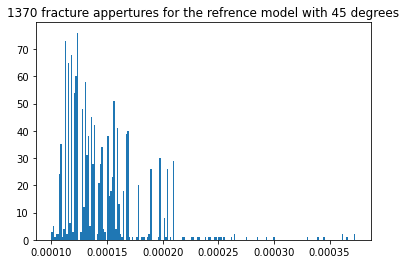

darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Total elapsed 35.325578 sec
	initialization 5.593238 sec
	newton update 0.000000 sec
	simulation 29.720890 sec
		jacobian assembly 2.098476 sec
			interpolation 1.212798 sec
				reservoir interpolation 1.209401 sec
					body generation 0.008346 sec
						point generation 0.006786 sec
				well controls interpolation 0.009512 sec
					body generation 0.000506 sec
						point generation 0.000410 sec
				well interpolation 0.000000 sec
		linear solver setup 8.147259 sec
			GMRES 8.145069 sec
				CPR 8.142957 sec
					AMG 4.852949 sec
					ILU(0) 3.125301 sec
		linear solver solve 18.411147 sec
			GMRES 18.406839 sec
				CPR 16.522826 sec
					AMG 7.977706 sec
					ILU(0) 7.310138 sec
				SPMV_bsr 0.929930 sec
				prec_comm 0.000000 sec
		newton update 0.472648 sec
			composition correction 0.106272 sec



In [174]:
#%%
#First we define the model that will be used as refference frac_aper = = 1e-3 (base case produced by Stephan)
angle_ref =45 #degress
NFractures = aperture_vec(angle_ref).shape[0]
frac_aper_het =  np.zeros(NFractures)
frac_aper_het = aperture_vec(angle_ref) #np.clip(np.random.normal(1e-3, 0.1*(1e-3), NFractures),0.0005,0.0015)
plt.hist(frac_aper_het, bins=200)
plt.title(f'{aperture_vec(angle_ref).shape[0]} fracture appertures for the refrence model with {angle_ref} degrees')
plt.show()

m_true0 = ModelDA(frac_aper =aperture_vec(angle_ref))
time_range = np.arange(0,2000, 10)+1
# After constructing the model, the simulator needs to be initialized. The init() class method is called, which is
# inherited (https://www.python-course.eu/python3_inheritance.php) from the parent class DartsModel (found in
# darts/models/darts_model.py (NOTE: This is not the same as the__init__(self, **) method which each class (should)
# have).


#m_true0.mesh_type = 'mesh_clean_very_coarse'
m_true0.init()
# Specify some other time-related properties (NOTE: all time parameters are in [days])
m_true0.params.max_ts = 1  # Adjust the maximum time-step as desired (this is overwriting the max_ts specified in model.py)
m_true0.run(time_range[-1])
m_true0.print_timers()
time_data0 = pd.DataFrame.from_dict(m_true0.physics.engine.time_data)

In [25]:
l = list()
for i, angle in enumerate([0,45,90]):
        #First we define the model that will be used as refference frac_aper = = 1e-3 (base case produced by Stephan)
    angle_ref = angle #degress
    NFractures = aperture_vec(angle_ref).shape[0]
    frac_aper_het =  np.zeros(NFractures)
    frac_aper_het = aperture_vec(angle_ref) #np.clip(np.random.normal(1e-3, 0.1*(1e-3), NFractures),0.0005,0.0015)
    model_i = ModelDA(frac_aper =aperture_vec(angle_ref))
    time_range = np.arange(0,2000, 10)+1
       
    model_i.init()
    # Specify some other time-related properties (NOTE: all time parameters are in [days])
    model_i.params.max_ts = 1  # Adjust the maximum time-step as desired (this is overwriting the max_ts specified in model.py)
    model_i.run(time_range[-1])
    model_i.print_timers()
    l.append(pd.DataFrame.from_dict(model_i.physics.engine.time_data))

darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Total elapsed 30.590208 sec
	initialization 5.046739 sec
	newton update 0.000000 sec
	simulation 25.529915 sec
		jacobian assembly 1.810773 sec
			interpolation 1.050157 sec
				reservoir interpolation 1.047099 sec
					body generation 0.004877 sec
						point generation 0.003903 sec
				well controls interpolation 0.007780 sec
					body generation 0.000310 sec
						point generation 0.000252 sec
				well interpolation 0.000000 sec
		linear solver setup 7.000225 sec
			GMRES 6.998221 sec
				CPR 6.996001 sec
					AMG 4.196479 sec
					ILU(0) 2.658104 sec
		linear solver solve 15.810658 sec
			GMRES 15.806615 sec
				CPR 14.164764 sec
					AMG 6.867305 sec
					ILU(0) 6.260210 sec
				SPMV_bsr 0.796420 sec
				prec_comm 0.000000 sec
		newton update 0.394613 sec
			composition correction 0.092307 sec

darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Total elapsed 31.224162 sec
	initializa

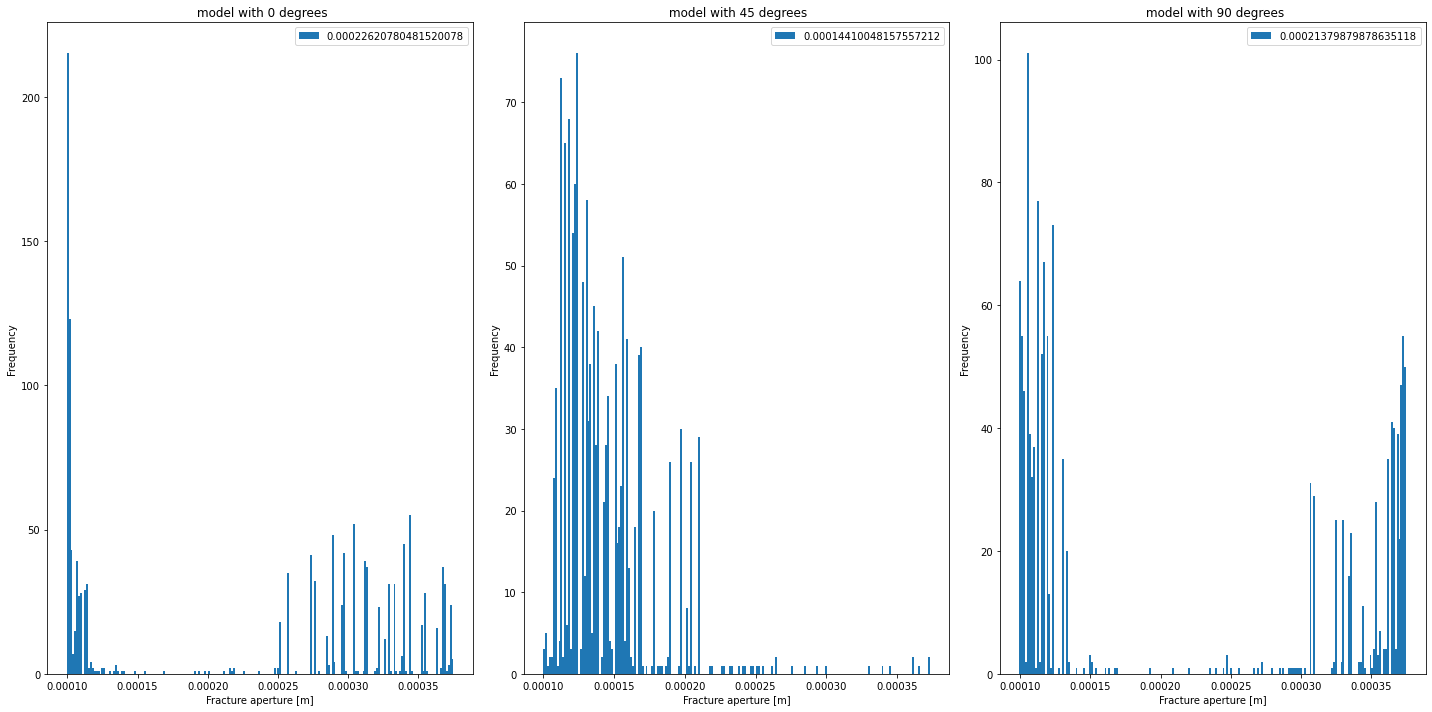

In [62]:
#create subplot of 3 rows and 1 column with histograms of the fracture appertures for the three different angles
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
for i, angle in enumerate([0,45,90]):
    ax[i].hist(aperture_vec(angle), bins=200)
    ax[i].set_title(f' model with {angle} degrees') # with mean aperture {aperture_vec(angle).mean()}.2f and min aperture {aperture_vec(angle).min()}') #use just 4 digits after the decimal point
    ax[i].set_xlabel('Aperture [mm]')
    ax[i].set_ylabel('Frequency')
    ax[i].set_xlabel('Fracture aperture [m]')
    ax[i].set_ylabel('Frequency')
    ax[i].legend([aperture_vec(angle).mean()])
plt.tight_layout()
plt.show()


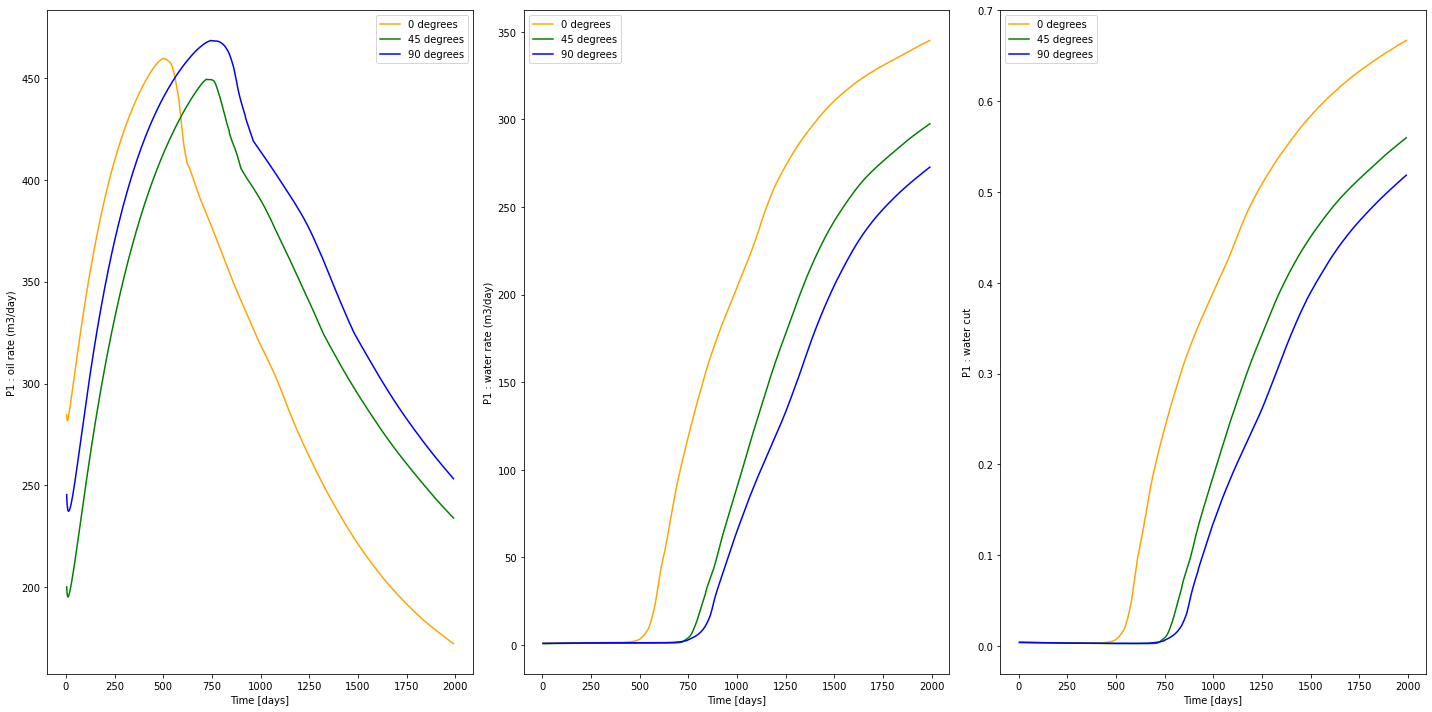

In [65]:
#creat a subplot of 'P1 : oil rate (m3/day)' , 'I1 : water rate (m3/day)' and 'P1 : liquid rate (m3/day)' for the three different angles
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].plot(l[0]['time'][10:],-1*l[0]['P1 : oil rate (m3/day)'][10:],color='orange', alpha=1)
ax[0].plot(l[1]['time'][10:],-1*l[1]['P1 : oil rate (m3/day)'][10:],color='green', alpha=1)
ax[0].plot(l[2]['time'][10:],-1*l[2]['P1 : oil rate (m3/day)'][10:],color='blue', alpha=1)
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('P1 : oil rate (m3/day)')
ax[0].legend(['0 degrees','45 degrees','90 degrees'])

ax[1].plot(l[0]['time'][10:],-1*l[0]['P1 : water rate (m3/day)'][10:],color='orange', alpha=1)
ax[1].plot(l[1]['time'][10:],-1*l[1]['P1 : water rate (m3/day)'][10:],color='green', alpha=1)
ax[1].plot(l[2]['time'][10:],-1*l[2]['P1 : water rate (m3/day)'][10:],color='blue', alpha=1)
ax[1].set_xlabel('Time [days]')
ax[1].set_ylabel('P1 : water rate (m3/day)')
ax[1].legend(['0 degrees','45 degrees','90 degrees'])


ax[2].plot(l[0]['time'][10:],l[0]['P1 : water rate (m3/day)'][10:]/(l[0]['P1 : liquid rate (m3/day)'][10:]),color='orange', alpha=1)
ax[2].plot(l[1]['time'][10:],l[1]['P1 : water rate (m3/day)'][10:]/(l[1]['P1 : liquid rate (m3/day)'][10:]),color='green', alpha=1)
ax[2].plot(l[2]['time'][10:],l[2]['P1 : water rate (m3/day)'][10:]/(l[2]['P1 : liquid rate (m3/day)'][10:]),color='blue', alpha=1)
ax[2].set_xlabel('Time [days]')
ax[2].set_ylabel('P1 : water cut')
ax[2].legend(['0 degrees','45 degrees','90 degrees'])

#ax[i].set_title(f'{l[i]['P1 : water rate (m3/day)'][10:].shape[0]} days for the model with {angle} degrees')

plt.tight_layout()
plt.show()


In [169]:
#wrap writing in vtf in a function
def write_vtf(m, angle_ref, filename):

    # Properties for writing to vtk format:
    # output_directory = 'trial_dir'  # Specify output directory here
    output_directory = filename
    num_wells_tot = 2  # Specify here how much wells are being used
    # Specify here the number of properties you want to extract (properties are based on selected physics, see model):
    tot_properties = 3

    # Calculate the size of the properties vector:
    tot_unknws = m.reservoir.unstr_discr.fracture_cell_count + m.reservoir.unstr_discr.matrix_cell_count + num_wells_tot*2


    # Allocate and store the properties in an array:
    property_array = np.empty((tot_unknws, tot_properties))
    property_array[:, 0] = m.physics.engine.X[:-1:2]
    property_array[:, 1] = m.physics.engine.X[1::2]
    property_array[:m.reservoir.unstr_discr.fracture_cell_count, 2] = aperture_vec(angle_ref)

    m.cell_property.append('frac_aper')

    # Write to vtk using class methods of unstructured discretizer (uses within meshio write to vtk function):
    return m.reservoir.unstr_discr.write_to_vtk(output_directory, property_array, m_true0.cell_property, 0)


In [170]:
#writw m_true0 to vtk
write_vtf(m_true0, angle_ref, 'change well')

Writing data to VTK file for 0-th reporting step


0

In [15]:
!jupyter nbconvert --to html teste_angleref.ipynb

[NbConvertApp] Converting notebook teste_angleref.ipynb to html
[NbConvertApp] Writing 351074 bytes to teste_angleref.html
